# How to use backpropagation to train a feedforward NN

This noteboo implements a simple single-layer architecture and forward propagation computations using matrix algebra and Numpy,the Python counterpart of linear algebra.


Please follow the installations [instructions](../installation.md).

## Imports & Settings 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd

import sklearn
from sklearn.datasets import make_circles

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns

In [3]:
# plotting style
sns.set_style('white')
# for reproducibility
np.random.seed(seed=42)

In [4]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()

## Input Data

### Generate random data

The target `y` represents two classes generated by two circular distribution that are not linearly separable because class 0 surrounds class 1.

We will generate 50,000 random samples in the form of two concentric circles with different radius using scikit-learn's make_circles function so that the classes are not linearly separable. 

In [5]:
# dataset params
N = 50000
factor = 0.1
noise = 0.1

In [6]:
n_iterations = 50000
learning_rate = 0.0001
momentum_factor = .5

In [7]:
# generate data
X, y = make_circles(
    n_samples=N,
    shuffle=True,
    factor=factor,
    noise=noise)

In [8]:
# define outcome matrix
Y = np.zeros((N, 2))
for c in [0, 1]:
    Y[y == c, c] = 1

$$X =\begin{bmatrix} 
x_{11} & x_{12} \\
\vdots & \vdots \\
x_{N1} & x_{N2}
\end{bmatrix}
\quad\quad
Y = \begin{bmatrix} 
y_{11} & y_{12}\\
\vdots & \vdots \\
y_{N1} & y_{N2} 
\end{bmatrix}$$

In [9]:
f'Shape of: X: {X.shape} | Y: {Y.shape} | y: {y.shape}'

'Shape of: X: (50000, 2) | Y: (50000, 2) | y: (50000,)'

### Visualize Data

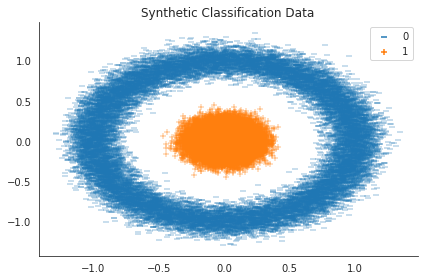

In [10]:
ax = sns.scatterplot(x=X[:, 0], 
                y=X[:, 1], 
                hue=y,
               style=y,
               markers=['_', '+'])
ax.set_title('Synthetic Classification Data')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'ffnn_data', dpi=300);

## Neural Network Architecture

### Hidden Layer Activations

The hidden layer $h$ projects the 2D input into a 3D space. To this end, the hidden layer weights are a $2\times3$ matrix $\mathbf{W}^h$, and the hidden layer bias vector $\mathbf{b}^h$ is a 3-dimensional vector:

\begin{align*}
\underset{\scriptscriptstyle 2 \times 3}{\mathbf{W}^h} =
\begin{bmatrix} 
w^h_{11} & w^h_{12} & w^h_{13} \\
w^h_{21} & w^h_{22} & w^h_{23}
\end{bmatrix}
&& \underset{\scriptscriptstyle 1 \times 3}{\mathbf{b}^h} = 
\begin{bmatrix} 
b^h_1 & b^h_2 & b^h_3
\end{bmatrix}
\end{align*}

The output layer values $\mathbf{Z}^h$ result from the dot product of the $N\times\ 2$ input data $\mathbf{X}$ and the the $2\times3$ weight matrix $\mathbf{W}^h$ and the addition of the $1\times3$ hidden layer bias vector $\mathbf{b}^h$:

$$\underset{\scriptscriptstyle N \times 3}{\mathbf{Z}^h} = \underset{\scriptscriptstyle N \times 2}{\vphantom{\mathbf{W}^o}\mathbf{X}}\cdot\underset{\scriptscriptstyle 2 \times 3}{\mathbf{W}^h} + \underset{\scriptscriptstyle 1 \times 3}{\mathbf{b}^h}$$

The logistic sigmoid function $\sigma$ applies a non-linear transformation to $\mathbf{Z}^h$ to yield  the hidden layer activations as an $N\times3$ matrix:

$$\underset{\scriptscriptstyle N \times 3}{\mathbf{H}} = \sigma(\mathbf{X} \cdot \mathbf{W}^h + \mathbf{b}^h) = \frac{1}{1+e^{−(\mathbf{X} \cdot \mathbf{W}^h + \mathbf{b}^h)}} = \begin{bmatrix} 
h_{11} & h_{12} & h_{13} \\
\vdots & \vdots & \vdots \\
h_{N1} & h_{N2} & h_{N3}
\end{bmatrix}$$

In [11]:
def logistic(z):
    """Logistic function."""
    return 1 / (1 + np.exp(-z))

In [12]:
def hidden_layer(input_data, weights, bias):
    """Compute hidden activations"""
    return logistic(input_data @ weights + bias)

### Output Activations

The values $\mathbf{Z}^o$ for the output layer $o$ are a $N\times2$ matrix that results from the dot product of the $\underset{\scriptscriptstyle N \times 3}{\mathbf{H}}$ hidden layer activation matrix with the $3\times2$ output weight matrix $\mathbf{W}^o$ and the addition of the $1\times2$ output bias vector $\mathbf{b}^o$:

$$\underset{\scriptscriptstyle N \times 2}{\mathbf{Z}^o} = \underset{\scriptscriptstyle N \times 3}{\vphantom{\mathbf{W}^o}\mathbf{H}}\cdot\underset{\scriptscriptstyle 3 \times 2}{\mathbf{W}^o} + \underset{\scriptscriptstyle 1 \times 2}{\mathbf{b}^o}$$

The Softmax function $\varsigma$ squashes the unnormalized probabilities predicted for each class  to lie within $[0, 1]$ and sum to 1.  The result is a $N\times2$ matrix with one column for each output class.

$$\underset{\scriptscriptstyle N \times 2}{\mathbf{\hat{Y}}} 
= \varsigma(\mathbf{H} \cdot \mathbf{W}^o + \mathbf{b}^o)
= \frac{e^{Z^o}}{\sum_{c=1}^C e^{\mathbf{z}^o_c}}
= \frac{e^{H \cdot W^o + \mathbf{b}^o}}{\sum_{c=1}^C e^{H \cdot \mathbf{w}^o_c + b^o_c}}
= \begin{bmatrix} 
\hat{y}_{11} & \hat{y}_{12}\\
\vdots & \vdots \\
\hat{y}_{n1} & \hat{y}_{n2} 
\end{bmatrix}$$

In [13]:
def softmax(z):
    """Softmax function"""
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [14]:
def output_layer(hidden_activations, weights, bias):
    """Compute the output y_hat"""
    return softmax(hidden_activations @ weights + bias)

### Forward Propagation

The `forward_prop` function combines the previous operations to yield the output activations from the  input data as a function of weights and biases. The `predict` function produces the binary class predictions given weights, biases, and input data.

In [15]:
def forward_prop(data, hidden_weights, hidden_bias, output_weights, output_bias):
    """Neural network as function."""
    hidden_activations = hidden_layer(data, hidden_weights, hidden_bias)
    return output_layer(hidden_activations, output_weights, output_bias)

In [16]:
def predict(data, hidden_weights, hidden_bias, output_weights, output_bias):
    """Predicts class 0 or 1"""
    y_pred_proba = forward_prop(data,
                                hidden_weights,
                                hidden_bias,
                                output_weights,
                                output_bias)
    return np.around(y_pred_proba)

### Cross-Entropy Loss

The cost function $J$ uses the cross-entropy loss $\xi$ that sums the deviations of the predictions for each class $c$  $\hat{y}_{ic}, i=1,...,N$ from the actual outcome.

$$J(\mathbf{Y},\mathbf{\hat{Y}}) = \sum_{i=1}^n \xi(\mathbf{y}_i,\mathbf{\hat{y}}_i) = − \sum_{i=1}^N \sum_{i=c}^{C} y_{ic} \cdot log(\hat{y}_{ic})$$

In [17]:
def loss(y_hat, y_true):
    """Cross-entropy"""
    return - (y_true * np.log(y_hat)).sum()

## Backpropagation

Backpropagation updates parameters values based on the partial derivative of the loss with respect to that parameter, computed using the chain rule.

### Loss Function Gradient

The derivative of the loss function $J$ with respect to each output layer activation $\varsigma(\mathbf{Z}^o_i), i=1,...,N$, is a very simple expression:

$$\frac{\partial J}{\partial z^0_i} = \delta^o = \hat{y}_i-y_i$$

See [here](https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function) and [here](https://deepnotes.io/softmax-crossentropy) for details on derivation.

In [18]:
def loss_gradient(y_hat, y_true):
    """output layer gradient"""
    return y_hat - y_true

### Output Layer Gradients

#### Output Weight Gradients

To propagate the updates back to the output layer weights, we take the partial derivative of the loss function with respect to the weight matrix:

$$
\frac{\partial J}{\partial \mathbf{W}^o} = H^T \cdot (\mathbf{\hat{Y}}-\mathbf{Y}) = H^T \cdot \delta^{o}
$$

In [19]:
def output_weight_gradient(H, loss_grad):
    """Gradients for the output layer weights"""
    return  H.T @ loss_grad

#### Output Bias Update

To update the output layer bias values, we similarly apply the chain rule to obtain the partial derivative of the loss function with respect to the bias vector:

$$\frac{\partial J}{\partial \mathbf{b}_{o}} 
= \frac{\partial \xi}{\partial \mathbf{\hat{Y}}} \frac{\partial \mathbf{\hat{Y}}}{\partial \mathbf{Z}^o}  \frac{\partial \mathbf{Z}^{o}}{\partial \mathbf{b}^o}
= \sum_{i=1}^N 1 \cdot (\mathbf{\hat{y}}_i - \mathbf{y}_i) 
= \sum_{i=1}^N \delta_{oi}$$

In [20]:
def output_bias_gradient(loss_grad):
    """Gradients for the output layer bias"""
    return np.sum(loss_grad, axis=0, keepdims=True)

### Hidden layer gradients

$$\delta_{h} 
= \frac{\partial J}{\partial \mathbf{Z}^h} 
= \frac{\partial J}{\partial \mathbf{H}} \frac{\partial \mathbf{H}}{\partial \mathbf{Z}^h} 
= \frac{\partial J}{\partial \mathbf{Z}^o} \frac{\partial \mathbf{Z}^o}{\partial H} \frac{\partial H}{\partial \mathbf{Z}^h}$$

In [21]:
def hidden_layer_gradient(H, out_weights, loss_grad):
    """Error at the hidden layer.
    H * (1-H) * (E . Wo^T)"""
    return H * (1 - H) * (loss_grad @ out_weights.T)

#### Hidden Weight Gradient

$$
\frac{\partial J}{\partial \mathbf{W}^h} = \mathbf{X}^T \cdot \delta^{h}
$$

In [22]:
def hidden_weight_gradient(X, hidden_layer_grad):
    """Gradient for the weight parameters at the hidden layer"""
    return X.T @ hidden_layer_grad

#### Hidden Bias Gradient

$$
\frac{\partial \xi}{\partial \mathbf{b}_{h}} 
= \frac{\partial \xi}{\partial H} \frac{\partial H}{\partial Z_{h}} \frac{\partial Z_{h}}{\partial \mathbf{b}_{h}}
= \sum_{j=1}^N \delta_{hj}
$$

In [23]:
def hidden_bias_gradient(hidden_layer_grad):
    """Gradient for the bias parameters at the output layer"""
    return np.sum(hidden_layer_grad, axis=0, keepdims=True)

## Initialize Weights

In [24]:
def initialize_weights():
    """Initialize hidden and output weights and biases"""

    # Initialize hidden layer parameters
    hidden_weights = np.random.randn(2, 3)
    hidden_bias = np.random.randn(1, 3)

    # Initialize output layer parameters
    output_weights = np.random.randn(3, 2)
    output_bias = np.random.randn(1, 2)
    return hidden_weights, hidden_bias, output_weights, output_bias

## Compute Gradients

In [25]:
def compute_gradients(X, y_true, w_h, b_h, w_o, b_o):
    """Evaluate gradients for parameter updates"""

    # Compute hidden and output layer activations
    hidden_activations = hidden_layer(X, w_h, b_h)
    y_hat = output_layer(hidden_activations, w_o, b_o)

    # Compute the output layer gradients
    loss_grad = loss_gradient(y_hat, y_true)
    out_weight_grad = output_weight_gradient(hidden_activations, loss_grad)
    out_bias_grad = output_bias_gradient(loss_grad)

    # Compute the hidden layer gradients
    hidden_layer_grad = hidden_layer_gradient(hidden_activations, w_o, loss_grad)
    hidden_weight_grad = hidden_weight_gradient(X, hidden_layer_grad)
    hidden_bias_grad = hidden_bias_gradient(hidden_layer_grad)

    return [hidden_weight_grad, hidden_bias_grad, out_weight_grad, out_bias_grad]

## Check Gradients

It's easy to make mistakes with the numerous inputs to the backpropagation algorithm. A simple way to test for accuracy is to compare the change in the output for slightly perturbed parameter values with the change implied by the computed gradient (see [here](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization) for more detail).

In [26]:
# change individual parameters by +/- eps
eps = 1e-4

# initialize weights and biases
params = initialize_weights()

# Get all parameter gradients
grad_params = compute_gradients(X, Y, *params)

# Check each parameter matrix
for i, param in enumerate(params):
    # Check each matrix entry
    rows, cols = param.shape
    for row in range(rows):
        for col in range(cols):
            # change current entry by +/- eps
            params_low = deepcopy(params)
            params_low[i][row, col] -= eps

            params_high = deepcopy(params)
            params_high[i][row, col] += eps

            # Compute the numerical gradient
            loss_high = loss(forward_prop(X, *params_high), Y)
            loss_low = loss(forward_prop(X, *params_low), Y)
            numerical_gradient = (loss_high - loss_low) / (2 * eps)

            backprop_gradient = grad_params[i][row, col]
            
            # Raise error if numerical and backprop gradient differ
            assert np.allclose(numerical_gradient, backprop_gradient), ValueError(
                    f'Numerical gradient of {numerical_gradient:.6f} not close to '
                    f'backprop gradient of {backprop_gradient:.6f}!')

print('No gradient errors found')

No gradient errors found


## Train Network

In [27]:
def update_momentum(X, y_true, param_list,
                    Ms, momentum_term,
                    learning_rate):
    """Update the momentum matrices."""
    # param_list = [hidden_weight, hidden_bias, out_weight, out_bias]
    # gradients = [hidden_weight_grad, hidden_bias_grad,
    #               out_weight_grad, out_bias_grad]
    gradients = compute_gradients(X, y_true, *param_list)
    return [momentum_term * momentum - learning_rate * grads
            for momentum, grads in zip(Ms, gradients)]

In [28]:
def update_params(param_list, Ms):
    """Update the parameters."""
    # param_list = [Wh, bh, Wo, bo]
    # Ms = [MWh, Mbh, MWo, Mbo]
    return [P + M for P, M in zip(param_list, Ms)]

In [29]:
def train_network(iterations=1000, lr=.01, mf=.1):
    # Initialize weights and biases
    param_list = list(initialize_weights())

    # Momentum Matrices = [MWh, Mbh, MWo, Mbo]
    Ms = [np.zeros_like(M) for M in param_list]

    train_loss = [loss(forward_prop(X, *param_list), Y)]
    for i in range(iterations):
        if i % 1000 == 0: print(f'{i:,d}', end=' ', flush=True)
        # Update the moments and the parameters
        Ms = update_momentum(X, Y, param_list, Ms, mf, lr)

        param_list = update_params(param_list, Ms)
        train_loss.append(loss(forward_prop(X, *param_list), Y))

    return param_list, train_loss

If you have time you can run the various parameter combinations to compare results..

In [30]:
# n_iterations = 20000
# results = {}
# for learning_rate in [.01, .02, .05, .1, .25]:
#     for momentum_factor in [0, .01, .05, .1, .5]:
#         print(learning_rate, momentum_factor)
#         trained_params, train_loss = train_network(iterations=n_iterations, lr=learning_rate, mf=momentum_factor)
#         results[(learning_rate, momentum_factor)] = train_loss[::1000]

In [31]:
trained_params, train_loss = train_network(iterations=n_iterations, 
                                           lr=learning_rate, 
                                           mf=momentum_factor)

0 1,000 2,000 3,000 4,000 5,000 6,000 7,000 8,000 9,000 10,000 11,000 12,000 13,000 14,000 15,000 16,000 17,000 18,000 19,000 20,000 21,000 22,000 23,000 24,000 25,000 26,000 27,000 28,000 29,000 30,000 31,000 32,000 33,000 34,000 35,000 36,000 37,000 38,000 39,000 40,000 41,000 42,000 43,000 44,000 45,000 46,000 47,000 48,000 49,000 

In [32]:
hidden_weights, hidden_bias, output_weights, output_bias = trained_params

### Plot Training Loss

This plot displays the training loss over 50K iterations for 50K training samples with a momentum term of 0.5 and a learning rate of 1e-4. 

It shows that it takes over 5K iterations for the loss to start to decline but then does so very fast. We have not uses stochastic gradient descent, which would have likely significantly accelerated convergence.

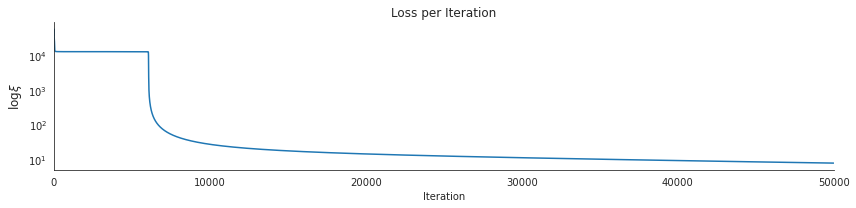

In [33]:
ax = pd.Series(train_loss).plot(figsize=(12, 3), title='Loss per Iteration', xlim=(0, n_iterations), logy=True)
ax.set_xlabel('Iteration')
ax.set_ylabel('$\\log \\xi$', fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'ffnn_loss', dpi=300)

## Decision Boundary

The following plots show the function learned by the neural network with a three-dimensional hidden layer form two-dimensional data with two classes that are not linearly separable as shown on the left. The decision boundary misclassifies very few data points and would further improve with continued training. 

The second plot shows the representation of the input data learned by the hidden layer. The network learns hidden layer weights so that the projection of the input from two to three dimensions enables the linear separation of the two classes. 

The last plot shows how the output layer implements the linear separation in the form of a cutoff value of 0.5 in the output dimension.

In [34]:
n_vals = 200
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid

# Initialize and fill the feature space
feature_space = np.zeros((n_vals, n_vals))
for i in range(n_vals):
    for j in range(n_vals):
        X_ = np.asarray([xx[i, j], yy[i, j]])
        feature_space[i, j] = np.argmax(predict(X_, *trained_params))

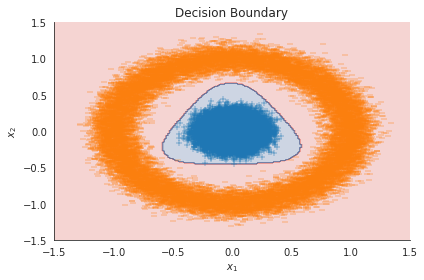

In [35]:
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([sns.xkcd_rgb["pale red"],
                       sns.xkcd_rgb["denim blue"]])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, feature_space, cmap=cmap, alpha=.25)

# Plot both classes on the x1, x2 plane
data = pd.DataFrame(X, columns=['$x_1$', '$x_2$']).assign(Class=pd.Series(y).map({0:'negative', 1:'positive'}))
sns.scatterplot(x='$x_1$', y='$x_2$', hue='Class', data=data, style=y, markers=['_', '+'], legend=False)
plt.title('Decision Boundary')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'boundary', dpi=300);

## Projection on Hidden Layer

In [36]:
n_vals = 25
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid
X_ = np.array([xx.ravel(), yy.ravel()]).T

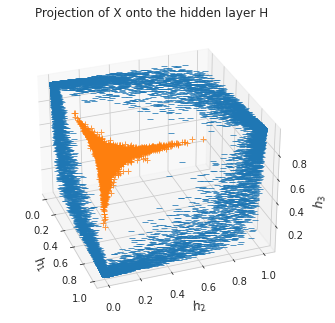

In [37]:
fig = plt.figure(figsize=(6, 4))
with sns.axes_style("whitegrid"):
    ax = Axes3D(fig)

ax.plot(*hidden_layer(X[y == 0], hidden_weights, hidden_bias).T,
        '_', label='negative class', alpha=0.75)
ax.plot(*hidden_layer(X[y == 1], hidden_weights, hidden_bias).T,
        '+', label='positive class', alpha=0.75)

ax.set_xlabel('$h_1$', fontsize=12)
ax.set_ylabel('$h_2$', fontsize=12)
ax.set_zlabel('$h_3$', fontsize=12)
ax.view_init(elev=30, azim=-20)
# plt.legend(loc='best')
plt.title('Projection of X onto the hidden layer H')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'projection3d', dpi=300)

## Network Output Surface Plot

In [38]:
zz = forward_prop(X_, hidden_weights, hidden_bias, output_weights, output_bias)[:, 1].reshape(25, -1)
zz.shape

(25, 25)

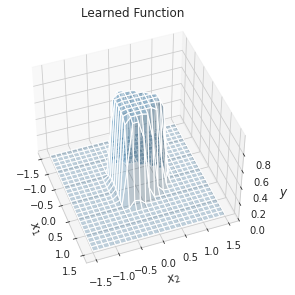

In [39]:
fig = plt.figure()
with sns.axes_style("whitegrid"):
    ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, zz, alpha=.25)
ax.set_title('Learned Function')
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
ax.set_zlabel('$y$', fontsize=12)
ax.view_init(elev=45, azim=-20)
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'surface', dpi=300);

## Summary

To sum up: we have seen how a very simple network with a single hidden layer with three nodes and a total of 17 parameters is able to learn how to solve a non-linear classification problem using backprop and gradient descent with momentum. 

We will next review key design choices useful to design and train more complex architectures before we turn to popular deep learning libraries that facilitate the process by providing many of these building blocks and automating the differentiation process to compute the gradients and implement backpropagation.